In [1]:
import requests
import json
from SPARQLWrapper import SPARQLWrapper, JSON

## Matching KG

In [ ]:
def linkingCMA(term):
    sparql = SPARQLWrapper("https://semantics.istc.cnr.it/hacid/sparql")
    sparql.setCredentials('hacid', 'hacid')
    sparql.setReturnFormat(JSON)
    variable = [term,term]
    sparql.setQuery("""
    PREFIX bif: <http://www.openlinksw.com/schemas/bif#>
    PREFIX rdf: <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
    PREFIX rdfs: <http://www.w3.org/2000/01/rdf-schema#>
    PREFIX naming: <https://w3id.org/hacid/onto/core/naming/>

    SELECT DISTINCT ?snomedId
    FROM <https://w3id.org/hacid/data/mdx>
    FROM <https://w3id.org/hacid/mdx/data/naming>
WHERE {
  {
    SELECT DISTINCT ?concept (STR(?name) as ?name)
    WHERE {
    
      ?concept naming:hasNaming/naming:hasName ?theName .
      ?theName ?property ?name .
      ?name bif:contains "'%s'" .
FILTER (?property IN (<https://w3id.org/hacid/onto/meta-inventory/normForm> , naming:lexicalItem))

    }
  }
  FILTER(LCASE(STR(?name)) = '%s') .
  BIND(REPLACE(STR(?concept), "https://w3id.org/hacid/mdx/data/", "") as ?snomedId) .
}
    """%(variable[0], variable[1])
    )
    
    try:
        ret = sparql.queryAndConvert()

        for r in ret["results"]["bindings"]:
            
            return r['snomedId']['value']
    except Exception as e:
        #print(e)
        return None

In [15]:
linkingCMA('covid 19')

'disorder/245e5085623eee82687a0a25e7365a22'

## Normalizer Endpoint

In [4]:
!curl --location 'localhost:8080/normalizer/normalizeAll?keepOrder=true'   --header 'Content-Type: application/json'   --data '["lymphocyte-predominant Hodgkin'\''s disease"]'

[{"text":"lymphocyte-predominant Hodgkin's disease","normalized":["lymphocyte predominant hodgkin disease"]}]

In [5]:
!curl --location 'localhost:8080/normalizer/normalize?keepOrder=true' \
  --header 'Content-Type: application/json' \
  --data '{"text":"lymphocyte-predominant Hodgkin'\''s disease"}'

["lymphocyte predominant hodgkin disease"]

In [8]:
!curl -X 'GET' 'http://minsky.istc.cnr.it:4321/search?query=obstructive%20sleep%20apnea&limit=1' -H 'accept: application/json'

{"query":"obstructive sleep apnea","query_embedded":"obstructive sleep apnea","results":[{"id":455148466602832225,"distance":1.0,"entity":{"term":"Obstructive sleep apnea","sctid":"78275009","term_type":"ALT","concept_type":"disorder","embedded_term":"Obstructive sleep apnea"}}]}

In [8]:
def normCMA (term):
    url = 'http://localhost:8080/normalizer/normalize?keepOrder=true'
    datas = {"text":term}
    headers = {'Content-Type': 'application/json'}
    r = requests.post(url, json=datas, headers=headers)
    return (r.json())

In [6]:
normCMA('Transoral thyroid surgery')

['transoral thyroid surgery']

## CMA + Embedding

In [9]:
def embed(query):
    base_url = 'http://minsky.istc.cnr.it:4321/search'
    params = {
        'query': query,
        'limit': 1
    }
    headers = {
        'accept': 'application/json'
    }
    response = requests.get(base_url, headers=headers, params=params)
    
    # Check if the request was successful
    if response.status_code == 200:
        return response.json()['results']  # Return JSON response if successful
    else:
        return {'error': f'Failed to fetch data: {response.status_code}'}

In [9]:
embed('Transoral thyroid surgery')

[{'id': 455148466602487875,
  'distance': 0.7276424765586853,
  'entity': {'sctid': '112890006',
   'term_type': 'FSN',
   'concept_type': 'procedure',
   'embedded_term': 'Lingual thyroidectomy by transoral route',
   'term': 'Lingual thyroidectomy by transoral route'}}]

In [14]:
embed('covid 19')

[{'id': 455148466603092474,
  'distance': 0.8361155986785889,
  'entity': {'sctid': '840539006',
   'term_type': 'PREF',
   'concept_type': 'disorder',
   'embedded_term': 'COVID-19',
   'term': 'COVID-19'}}]

In [12]:
def CMA (term):
    norms = normCMA(term)
    print(norms)
    output = [linkingCMA(norm) for norm in norms]
    print(output)
    embeds = embed(norms)
    print(embeds[0]['distance'])
    results = output if output[0] is not None else [item['entity']['sctid'] for item in embeds if item ['distance'] > 0.85]
    #results = output if output[0] is not None else [embeds[0]['entity']['sctid'] if embeds[0]['distance'] >= 0.725]
    print(results)
    return results

In [13]:
CMA("covid 19")

['covid 19']
['disorder/245e5085623eee82687a0a25e7365a22']
0.8361155986785889
['disorder/245e5085623eee82687a0a25e7365a22']


['disorder/245e5085623eee82687a0a25e7365a22']

In [13]:
import ast

def load_strings_from_file(filename):
    try:
        with open(filename, 'r') as file:
            data = []
            for line in file:
                # Remove leading/trailing whitespace and convert string to list
                line = line.strip()
                if line:  # Check if line is not empty
                    # Remove square brackets and split into list
                    line = line[1:-1]  # Remove square brackets
                    strings = [s.strip().strip("'").strip('"') for s in line.split(',')]
                    data.append(strings)
        return data
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return []
    except Exception as e:
        print(f"An error occurred: {e}")
        return []

# Example usage
filename = 'rag_result_1.txt'
data = load_strings_from_file(filename)
print(data)

[['History of Present Illness', 'COVID-19', 'family', 'fever', 'cough', 'dyspnea', 'Past Medical History', 'Hypertension', 'HIV', 'not on HAART', 'Type 2 diabetes mellitus', 'not on insulin', 'history of myocardial infarction', 'remote stroke', 'Heart failure with reduced ejection fraction', 'last ejection fraction of 40%', 'Medications', 'No allergies to any medications', 'amlodipine', 'atorvastatin', 'clopidogrel', 'furosemide', 'metformin', 'spironolactone', 'Social History', 'former smoker', '20py', 'history has intercourse with male partners', 'lives alone at home', 'no EtOH or drug usage that family is aware of', 'works as a hairdresser', 'Physical Exam', 'NEURO', 'alert and oriented x 1', 'motor and sensory function grossly intact', 'CV', 'tachycardia', 'regular rhythm', 'unable to ascertain m/r/g', 'MSK', 'no edema', 'warm to touch', 'PULM', 'increased work of breathing', 'using accessory muscles', 'diminished breath sounds bilaterally', 'no rhonchi/rales', 'no stridor', 'obese

In [14]:
data[31]

['Weight gain',
 'Dyspnea on exertion',
 'Nausea',
 'Dry heaving',
 'Dull pain in epigastric area',
 'Ibuprofen',
 'Heat packs',
 'Fever',
 'Chills',
 'Chest pain',
 'Palpitations',
 'Shortness of breath at rest',
 'Dysuria',
 'Menorrhagia',
 'Weight loss',
 'Tonsillectomy',
 'Green tea supplement',
 'Abdominal discomfort',
 'Tachycardia',
 'Regular rhythm',
 'Murmur',
 'LEE',
 'T 37 C',
 'HR 110 bpm',
 'RR 14',
 'SpO2 95% on RA',
 'BP 102/62',
 'BMI 24',
 'EOMI',
 'PERRL',
 'Scleral icterus',
 'AAOx3',
 'MAE',
 'CTAB',
 'Non-labored',
 'Warm',
 'Dry',
 'Rashes',
 'Lipase',
 'TSH',
 'Urine HCG',
 'BMP',
 'Na',
 'K',
 'Cl',
 'CO2',
 'BUN',
 'sCr',
 'BG',
 'Ca',
 'AST',
 'ALT',
 'ALP',
 'TBili',
 'Total protein',
 'Albumin',
 'WBC',
 'Hgb',
 'Plt',
 'Gallstones',
 'Thickened gallbladder wall',
 'Cholecystitis',
 'Hypoxia',
 'SpO2 70-80% on RA',
 'IV antibiotics',
 'General surgery',
 'Cholecystectomy',
 'Minimal blood loss',
 'Ejection fraction',
 'Stage 3 diastolic dysfunction',
 'Globa

In [15]:
flattened_ent = [item for sublist in data for item in sublist]

In [16]:
len(flattened_ent)

3534

In [17]:
distances = []
for elem in flattened_ent:
    ent_emb = embed(normCMA(elem))
    res = ent_emb[0]['distance']
    distances.append(res)

In [20]:
len([d for d in distances if d > 0.85]), len(distances), (len([d for d in distances if d > 0.85])/len(distances))

(2477, 3534, 0.7009054895302773)

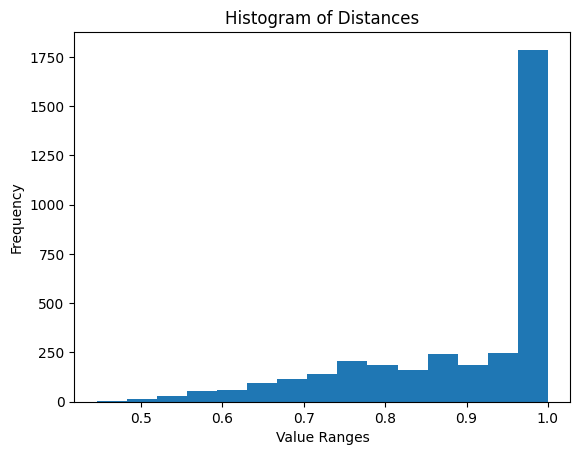

In [21]:
import matplotlib.pyplot as plt

plt.hist(distances, bins=15)  # Adjust bins for desired range representation
plt.title('Histogram of Distances')
plt.xlabel('Value Ranges')
plt.ylabel('Frequency')

# Show plot
plt.show()

In [86]:
embed('Transoral thyroid surgery')

[{'id': 455148466602487875,
  'distance': 0.7276424765586853,
  'entity': {'sctid': '112890006',
   'term_type': 'FSN',
   'concept_type': 'procedure',
   'embedded_term': 'Lingual thyroidectomy by transoral route',
   'term': 'Lingual thyroidectomy by transoral route'}}]

In [87]:
embed('Vitamin]The answer is incorrect. The correct answer is:Answer::')

[{'id': 455148466602388863,
  'distance': 0.5031164884567261,
  'entity': {'term': 'Advice to change vitamin intake',
   'sctid': '289182003',
   'term_type': 'ALT',
   'concept_type': 'procedure',
   'embedded_term': 'Advice to change vitamin intake'}}]

In [22]:
results = []
for a in data[1]:
    res = (a, CMA(a))
    results.append(res)

print (results)


['dermatitis']
1.0000001192092896
['703938007']
['famotidine']
1.0000001192092896
['387211002']
['hydroxyzine']
1.0
['372856003']
['prednisone']
1.0000001192092896
['116602009']
['diabetes mellitus']
1.0
['73211009']
['adhd']


0.7125796675682068
['406506008']
['jaundice']
1.0000001192092896
['18165001']
['liver biopsy']
0.9719003438949585
['86259008']
['cholestasis']
1.0
['33688009']
['necrosis']
1.0
['6574001']
['granuloma']
1.0000001192092896
['45647009']
['steatosis']
0.9999999403953552
['1187537008']
['iron accumulation']
0.9125242829322815
['60737008']
['creatin']
0.9545704126358032
['14804005']
['caffein']
0.930136501789093
['255641001']
['whey protein']
1.0
['878874009']
['vitamin answer be incorrect correct answer is answer', 'vitamin answer is incorrect correct answer is answer', 'vitamin answer is incorrect correct answer be answer', 'vitamin answer i incorrect correct answer is answer', 'vitamin answer i incorrect correct answer i answer', 'vitamin answer is incorrect correct answer i answer', 'vitamin answer be incorrect correct answer i answer', 'vitamin answer i incorrect correct answer be answer', 'vitamin answer be incorrect correct answer be answer']
0.567573070526123
[]
[('Dermatitis', ['70

In [23]:
results

[('Dermatitis', ['703938007']),
 ('Famotidine', ['387211002']),
 ('Hydroxyzine', ['372856003']),
 ('Prednisone', ['116602009']),
 ('Diabetes mellitus', ['73211009']),
 ('ADHD', ['406506008']),
 ('Jaundice', ['18165001']),
 ('Liver biopsy', ['86259008']),
 ('Cholestasis', ['33688009']),
 ('Necrosis', ['6574001']),
 ('Granuloma', ['45647009']),
 ('Steatosis', ['1187537008']),
 ('Iron accumulation', ['60737008']),
 ('Creatine', ['14804005']),
 ('Caffeine', ['255641001']),
 ('Whey protein', ['878874009']),
 ('Vitamin]The answer is incorrect. The correct answer is:Answer::', [])]

In [24]:
def load_json_file(filename):
    try:
        with open(filename, 'r') as file:
            data = json.load(file)
            return data
    except FileNotFoundError:
        print(f"File {filename} not found.")
        return None
    except json.JSONDecodeError as e:
        print(f"Error parsing JSON: {e}")
        return None

# Example usage
filename = 'findings.json'
findings = load_json_file(filename)

In [25]:
cases = list(findings.keys())

In [26]:
mentions = dict(zip(cases, data))

In [27]:
mentions["https://w3id.org/hacid/mdx/data/clinicalcase/02d6cb624c9e48879c5c4b6ca51daf1f"]

['History of Present Illness',
 'COVID-19',
 'family',
 'fever',
 'cough',
 'dyspnea',
 'Past Medical History',
 'Hypertension',
 'HIV',
 'not on HAART',
 'Type 2 diabetes mellitus',
 'not on insulin',
 'history of myocardial infarction',
 'remote stroke',
 'Heart failure with reduced ejection fraction',
 'last ejection fraction of 40%',
 'Medications',
 'No allergies to any medications',
 'amlodipine',
 'atorvastatin',
 'clopidogrel',
 'furosemide',
 'metformin',
 'spironolactone',
 'Social History',
 'former smoker',
 '20py',
 'history has intercourse with male partners',
 'lives alone at home',
 'no EtOH or drug usage that family is aware of',
 'works as a hairdresser',
 'Physical Exam',
 'NEURO',
 'alert and oriented x 1',
 'motor and sensory function grossly intact',
 'CV',
 'tachycardia',
 'regular rhythm',
 'unable to ascertain m/r/g',
 'MSK',
 'no edema',
 'warm to touch',
 'PULM',
 'increased work of breathing',
 'using accessory muscles',
 'diminished breath sounds bilaterall

In [28]:
def dict_to_list_of_lists(data_dict):
    result = []
    for key, values in data_dict.items():
        for value in values:
            try:
                # Simulate an error for demonstration
                if CMA(value) == 'string2':  # Example condition to trigger an error
                    raise ValueError(f"Error processing {value}")
                result.append([key, value, CMA(value), 1.0, 'RAG'])
            except Exception as e:
                print(f"Error occurred: {e}. Skipping {value}.")
    return result

# Convert dictionary to list of lists with error handling
result = dict_to_list_of_lists(mentions)
print(result)

['history present illness']
0.9332497119903564
['422625006']
['history present illness']
0.9332497119903564
['422625006']
['covid 19']
0.8361155986785889
['disorder/245e5085623eee82687a0a25e7365a22']
['covid 19']
0.8361155986785889
['disorder/245e5085623eee82687a0a25e7365a22']
['family']
1.0
['35359004']
['family']
1.0
['35359004']
['fever']
0.9999998807907104
['386661006']
['fever']
0.9999998807907104
['386661006']
['cough']
0.9999998211860657
['49727002']
['cough']
0.9999998211860657
['49727002']
['dyspnea']
1.0
['267036007']
['dyspnea']
1.0
['267036007']
['past medical history']
0.9999999403953552
['417662000']
['past medical history']
0.9999999403953552
['417662000']
['hypertension']
0.9999999403953552
['38341003']
['hypertension']
0.9999999403953552
['38341003']
['hiv']
0.9999999403953552
['19030005']
['hiv']
0.9999999403953552
['19030005']
['not haart']
0.583566427230835
[]
['not haart']
0.583566427230835
[]
['type 2 diabetes mellitus']
1.0
['disorder/2434af72bf20d5b2e41cc689bbd6

In [34]:
filtered_result = [row for row in result if row[2]]

In [ ]:
filtered_result[:2]

[['https://w3id.org/hacid/mdx/data/clinicalcase/02d6cb624c9e48879c5c4b6ca51daf1f',
  'History of Present Illness',
  ['422625006'],
  1.0,
  'RAG'],
 ['https://w3id.org/hacid/mdx/data/clinicalcase/02d6cb624c9e48879c5c4b6ca51daf1f',
  'COVID-19',
  ['disorder/245e5085623eee82687a0a25e7365a22'],
  1.0,
  'RAG']]

In [1]:
len(filtered_result), len(result), (len(filtered_result)/len(result))

NameError: name 'filtered_result' is not defined

In [37]:
import csv

csv_file_path = 'triples.csv'  # Choose your desired file name

try:
    with open(csv_file_path, 'w', newline='', encoding='utf-8') as csvfile:
        csv_writer = csv.writer(csvfile) # You can customize the delimiter, quotechar, etc. here

        #Optionally write a header row
        header = ['caseURI', 'mentions', 'sctid', 'relevance', 'methods']
        csv_writer.writerow(header)

        csv_writer.writerows(filtered_result)

    print(f"Data successfully written to {csv_file_path}")

except Exception as e:
    print(f"An error occurred: {e}")

Data successfully written to triples.csv
